In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

In [2]:
tdf = pd.read_csv('../../data/country_gtd.csv', index_col=0)
tdf = tdf[(tdf.iyear>=2001) & (tdf.iyear <= 2005)]
print(len(tdf),  len(tdf[tdf.gname == 'Unknown']) )
drop_names = ['Unknown', 'Other', "Kurdistan Workers' Party (PKK)", \
              'Civil Association for Peace in Colombia, Asocipaz', 'Gunmen', 'Rebels',\
              'Left-Wing Guerrillas', 'Left-Wing Extremists', 'Individual']
tdf = tdf[-tdf.gname.isin(drop_names)]
print(len(tdf))
tdf.nkill.fillna(0, inplace=True)
tdf.head()

1962 1039
879


/Users/adampah/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,7,18,19,32,34,62,63,65,73,76,79,94,96,114,115,121,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
22024,200101000001,2001,1,0,"January 8-9, 2001",0,NaN,45,Colombia,3,...,Sources imply that the attack may have taken p...,"""Twenty murdered in attacks across Colombia at...","""Colombia violence leaves 35 dead,"" Agence Fra...",NaN,UMD Schmid 2012,-9,-9,0,-9,NaN
22026,200101010002,2001,1,1,NaN,1,2001-01-07,45,Colombia,3,...,The fate of the seven hostages not released wi...,“Colombia – Kidnapping 17 Kidnap Victims Freed...,“Paramilitary Group Releases 17 Peasants it Ca...,NaN,CETIS,0,0,0,0,NaN
22035,200101030006,2001,1,3,NaN,0,NaN,45,Colombia,3,...,NaN,"""At least 11 murdered in northwest Colombia,"" ...","""Eleven killed in northwestern Colombia town,""...","Michael Easterbrook, ""Colombia envoy on missio...",UMD Schmid 2012,-9,-9,0,-9,NaN
22041,200101050006,2001,1,5,NaN,0,NaN,45,Colombia,3,...,Sources provide different locations for the in...,"""Thirteen die in second regional massacre,"" As...","""Twelve dead in second Colombia massacre in tw...","""Twelve Colombian farm workers killed - parami...",UMD Schmid 2012,0,0,0,0,NaN
22045,200101060001,2001,1,6,NaN,0,NaN,45,Colombia,3,...,The Caño Limón-Coveñas pipeline travels 780 ki...,"Center For Terrorism and Intelligence Studies,...","“Rebels Sabotage Cano Limon Pipeline,” Busines...","“ELN Blaimed for Cano-Limon Pipeline Attack,” ...",CETIS,0,1,1,1,NaN


In [34]:
tdf['strdate'] = tdf.apply(lambda x: str(x['imonth']) + '-' + str(x['iday']) + '-' + str(x['iyear']), axis=1)
from datetime import datetime
dates = []
for x in tdf.strdate:
    try:
        dates.append(datetime.strptime(x, '%m-%d-%Y'))
    except:
        parts = x.split('-')
        dates.append( datetime.strptime('-'.join([parts[0], str(int(parts[1])+1), parts[2]]), '%m-%d-%Y') )
tdf['datetime'] = dates
tdf['date'] = pd.to_datetime(tdf['datetime'])
tdf.groupby(['date', 'gname']).agg({'eventid':'count'}).max()

eventid    11
dtype: int64

In [15]:
# gtd2philips = dict(pd.read_csv('../../data/translation.csv', header=None).values.tolist())
    
# philips2gtd = {}
# for k,v in gtd2philips.items():
#     if v not in philips2gtd:
#         philips2gtd[v] = k
#     else:
#         pass

In [16]:
# for k,v in philips2gtd.items():
#     try:
#         if 'tawhid' in k.lower() or ' land ' in k.lower():
#             print(k, '----', v)
#     except AttributeError:
#         pass

In [17]:
# for gname in tdf.gname.unique():
#     if 'tawhid' in gname.lower() or ' rivers ' in gname.lower():
#         print(gname)

# Get to capacity from: 

number casualties (log-mean)

number of weapons types

number of attack types 

In [20]:
def condense_columns(columns, df, cfname):
    groupdata = []
    for (gname, country), groupdf in df.groupby(['gname', 'country_txt']):
        typelist = []
        for c in columns:
            typelist.extend(groupdf[c].values.tolist())
        unique_types = [x for x in list(set(typelist)) if np.isnan(x)==False]
        groupdata.append([gname, country, len(unique_types)])
    return pd.DataFrame(groupdata, columns = ['gname', 'country_txt', cfname])

def clean_names(x, final_name, input_names):
    if x in input_names:
        return final_name
    else:
        return x
    
    
#We need to clean the groupnames

tdf['gname'] = tdf['gname'].apply(lambda x: clean_names(x, 'AQI', ['Tawhid and Jihad', 'Al-Qa`ida in Iraq']))
tdf['gname'] = tdf['gname'].apply(lambda x: clean_names(x, 'Al-Qaeda', ['Al-Qa`ida']))
tdf['gname'] = tdf['gname'].apply(lambda x: clean_names(x, 'United Self Defense Units of Colombia (AUC)', ['Death Squad', 'Right-Wing Death Squad', 'Right-Wing Paramilitaries', 'Paramilitaries']))
tdf['gname'] = tdf['gname'].apply(lambda x: clean_names(x, 'Taliban', ['Islamic Movement of Uzbekistan (IMU)']))
#First we need to make the log nkills
tdf['lognkill'] = tdf.nkill.apply(lambda x: np.log(x+1))
#Now we get the basic information
base_stats_df = tdf.groupby(['gname', 'country_txt']).agg({'lognkill':'mean', 'eventid':'count'}).reset_index()
#Now we get the attack types
attack_type_df = condense_columns(['attacktype1', 'attacktype2', 'attacktype3'], tdf, 'attack_types')
#Now we get the weapon types
weapon_type_df = condense_columns(['weaptype1', 'weaptype2', 'weaptype3', 'weaptype4'], tdf, 'weapon_types')
#Now I merge the weapon and attacks
attr_df = pd.merge(attack_type_df, weapon_type_df, on=['gname', 'country_txt'])
#Now I merge it all
group_attr = pd.merge(base_stats_df, attr_df, on=['gname', 'country_txt'])
group_attr

,gname,country_txt,lognkill,eventid,attack_types,weapon_types
0,1920 Revolution Brigades,Iraq,2.138333,2,1,1
1,AQI,Iraq,1.826740,120,6,5
2,Abu Hafs al-Masri Brigades,Iraq,2.079442,1,1,1
3,Al Zawahiri Loyalists,Iraq,0.000000,1,1,1
4,Al-Qaeda,Afghanistan,0.973233,19,3,2
5,Ansar al-Din,Iraq,0.000000,1,1,1
6,Ansar al-Islam,Iraq,2.191229,7,2,2
7,Ansar al-Jihad,Iraq,0.000000,1,1,1
8,Ansar al-Sunna,Iraq,1.822406,16,4,5
9,Armed Vanguards of a Second Mohammed Army,Iraq,3.218876,1,1,1


0.899198570489534

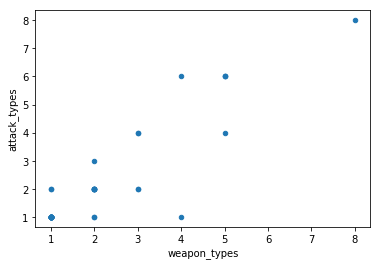

In [7]:
group_attr.plot(kind='scatter', x='weapon_types', y='attack_types')

group_attr['weapon_types'].corr(group_attr['attack_types'])

0.17047309274434841

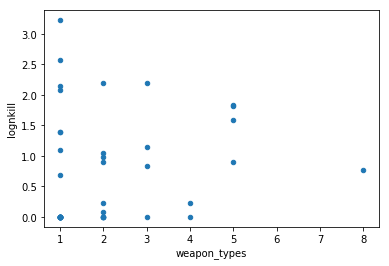

In [8]:
group_attr.plot(kind='scatter', x='weapon_types', y='lognkill')

group_attr['weapon_types'].corr(group_attr['lognkill'])

0.20017565753342678

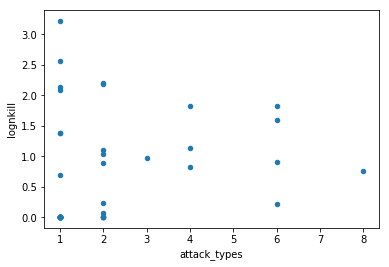

In [9]:
group_attr.plot(kind='scatter', x='attack_types', y='lognkill')

group_attr['attack_types'].corr(group_attr['lognkill'])

# And now for the regression

In [10]:
import statsmodels.formula.api as smf

fitmodel = smf.ols(formula='lognkill ~ attack_types -1', data=group_attr).fit()
fitmodel.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lognkill   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     22.11
Date:                Fri, 27 Jul 2018   Prob (F-statistic):           2.78e-05
Time:                        16:42:22   Log-Likelihood:                -57.803
No. Observations:                  43   AIC:                             117.6
Df Residuals:                      42   BIC:                             119.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
attack_types     0.2423      0.052      4.702      0.000       0.138       0.346
==============================================================================
Omnibus:                       12.677   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.849
Skew:                           1.237   Prob(JB):                      0.00162
Kurtosis:                       4.025   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
mult = ( group_attr.eventid.mean()/(365*4 + 1) / group_attr.lognkill.mean() )* 0.8
group_attr['mu'] = group_attr.attack_types.apply(lambda gx: fitmodel.params['attack_types'] * mult * gx)
group_attr

,gname,country_txt,lognkill,eventid,attack_types,weapon_types,mu
0,1920 Revolution Brigades,Iraq,2.138333,2,1,1,0.003729
1,AQI,Iraq,1.826740,120,6,5,0.022371
2,Abu Hafs al-Masri Brigades,Iraq,2.079442,1,1,1,0.003729
3,Al Zawahiri Loyalists,Iraq,0.000000,1,1,1,0.003729
4,Al-Qaeda,Afghanistan,0.973233,19,3,2,0.011186
5,Ansar al-Din,Iraq,0.000000,1,1,1,0.003729
6,Ansar al-Islam,Iraq,2.191229,7,2,2,0.007457
7,Ansar al-Jihad,Iraq,0.000000,1,1,1,0.003729
8,Ansar al-Sunna,Iraq,1.822406,16,4,5,0.014914
9,Armed Vanguards of a Second Mohammed Army,Iraq,3.218876,1,1,1,0.003729


In [12]:
countries = group_attr.country_txt.unique()
for country in countries:
    group_attr[group_attr.country_txt == country].loc[:, ['gname', 'mu']].to_csv('../../data/' + country + '_mus.csv', index=False)

# And now to clean the excel file with the networks

In [21]:
sheetnames = ['Iraq_edges', 'Afghanistan_edges', 'Colombia_edges']
net_dfs = {}
for sheetname in sheetnames:
    net_dfs[sheetname] = pd.read_excel('../../data/full_edges_bycountry.xls', sheetname=sheetname)
    
net_gnames = []
for sheet in net_dfs:
    net_gnames.extend(net_dfs[sheet].Source.values.tolist())
    net_gnames.extend(net_dfs[sheet].Target.values.tolist())
    
net_gnames = list(set(net_gnames))

for ngname in net_gnames:
    if ngname not in group_attr.gname.values.tolist():
        print(ngname)

/Users/adampah/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [22]:
for sheetname in net_dfs:
    country = sheetname.split('_')[0]
    net_dfs[sheetname].loc[:, ['Source', 'Target']].to_csv('../../data/' + country + '_edges.csv', index=None)